# Calculating the pairwise RMSD of a trajectory

**Last updated:** June 26, 2020 with MDAnalysis 1.0.0

**Minimum version of MDAnalysis:** 0.17.0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* MDAnalysisTests
* matplotlib

**See also**

* [1D RMSD](rmsd.ipynb)
* [RMSF](rmsf.ipynb)


<div class="alert alert-info">
    
**Note**

MDAnalysis implements RMSD calculation using the fast QCP algorithm (<a data-cite="theobald_rapid_2005" href="https://doi.org/10.1107/S0108767305015266">Theobald, 2005</a>). Please cite (<a data-cite="theobald_rapid_2005" href="https://doi.org/10.1107/S0108767305015266">Theobald, 2005</a>) when using the ``MDAnalysis.analysis.align`` module in published work.

</div>

In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD, CRD, DCD2
from MDAnalysis.analysis import diffusionmap, align, rms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading files

The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme. (<a data-cite="beckstein_zipping_2009" href="https://doi.org/10.1016/j.jmb.2009.09.009">Beckstein *et al.*, 2009</a>) The trajectories sample a transition from a closed to an open conformation.

In [2]:
adk_open = mda.Universe(CRD, DCD2)
adk_closed = mda.Universe(PSF, DCD)

## Background

While [1-dimensional RMSD](rmsd.ipynb) is a quick way to estimate how much a structure changes over time, it can be a misleading measure. It is easy to think that two structures with the same RMSD from a reference frame are also similar; but in fact, they can be very different. Instead, calculating the RMSD of each frame in the trajectory to all other frames in the other trajectory can contain much more information. This measure is often called the pairwise, all-to-all, or 2D RMSD.

The other, or reference, trajectory in pairwise RMSD can either be the first trajectory, or another one. If the pairwise RMSD of a trajectory is calculated to itself, it can be used to gain insight into the conformational convergence of the simulation. The diagonal of the plot will be zero in this case (as this represents the RMSD of a structure to itself). Blocks of low RMSD values *along* the diagonal indicate similar structures, suggesting the occupation of a given state. Blocks of low RMSD values *off* the diagonal indicate that the trajectory is revisiting an earlier state. Please see the living guide [Best Practices for Quantification of Uncertainty and Sampling Quality in Molecular Simulations by Grossfield et *al.*](https://github.com/dmzuckerman/Sampling-Uncertainty) for more on using 2D RMSD as a measure of convergence. MDAnalysis provides a [DistanceMatrix](#Pairwise-RMSD-of-a-trajectory-to-itself) class for easy calculation of the pairwise RMSD of a trajectory to itself.

When the other trajectory in pairwise RMSD is a different trajectory, the pairwise RMSD can be used to compare the similarity of the two conformational ensembles. There is no requirement that the two trajectories be the same length. In this case, the diagonal is no longer necessarily zero. Blocks of low RMSD values anywhere indicate that the two trajectories are sampling similar states. [Pairwise RMSDs with different trajectories must be manually calculated in MDAnalysis](#Pairwise-RMSD-between-two-trajectories).

## Pairwise RMSD of a trajectory to itself

In order to calculate the pairwise RMSD of a trajectory to itself, you should begin by aligning the trajectory in order to minimise the resulting RMSD. You may not have enough memory to do this `in_memory`, in which case you can write out the aligned trajectory to a file (please see [the aligning tutorials](aligning_trajectory.ipynb#Aligning-a-trajectory-with-AlignTraj) for more).

In [3]:
aligner = align.AlignTraj(adk_open, adk_open, select='name CA', 
                          in_memory=True).run()

We can then calculate a pairwise RMSD matrix with the `diffusionmap.DistanceMatrix` class, by using the default the `rms.rmsd` metric. 

In [4]:
matrix = diffusionmap.DistanceMatrix(adk_open, select='name CA').run()

The results array is in `matrix.dist_matrix` as a square array with the shape (#n_frames, #n_frame).

In [5]:
matrix.dist_matrix.shape

(102, 102)

We can use the common plotting package [matplotlib](https://matplotlib.org/3.1.1/gallery/index.html) to create a heatmap from this array. For other ways to plot heat maps, you can look at the [seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html), [plotly](https://plotly.com/python/heatmaps/) (for interactive images), or [holoviews](http://holoviews.org/reference/elements/bokeh/HeatMap.html) (also interactive) packages.

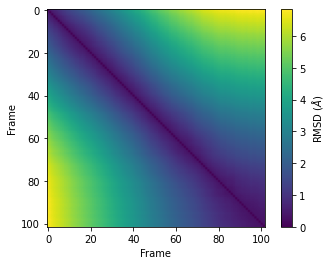

In [6]:
plt.imshow(matrix.dist_matrix, cmap='viridis')
plt.xlabel('Frame')
plt.ylabel('Frame')
plt.colorbar(label=r'RMSD ($\AA$)')

## Pairwise RMSD between two trajectories

Calculating the 2D RMSD between two trajectories is a bit more finicky; `DistanceMatrix` can only calculate the RMSD of a trajectory to itself. Instead, we do it the long way by simply calculating the RMSD of each frame in the second trajectory, to each frame in the first trajectory.

First we set up a 2D numpy array a shape corresponding to the length of each of our trajectories to store our results. To start off, it is populated with zeros.

In [7]:
prmsd = np.zeros((len(adk_open.trajectory),  # y-axis
                  len(adk_closed.trajectory)))  # x-axis

Then we iterate through each frame of the `adk_open` trajectory (our y-axis), and calculate the RMSD of `adk_closed` to each frame, storing it in the `prmsd` array.

In [8]:
for i, frame_open in enumerate(adk_open.trajectory):
    r = rms.RMSD(adk_closed, adk_open, select='name CA', 
                 ref_frame=i).run()
    prmsd[i] = r.rmsd[:, -1]  # select 3rd column with RMSD values

We plot it below. As you can see, there is no longer a line of zero values across the diagonal. Here, the frames of `adk_closed` and `adk_open` are similar but not identical.

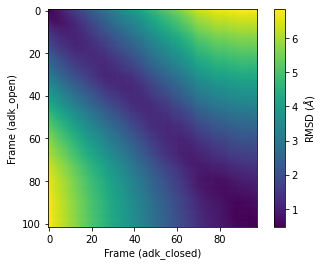

In [9]:
plt.imshow(prmsd, cmap='viridis')
plt.xlabel('Frame (adk_closed)')
plt.ylabel('Frame (adk_open)')
plt.colorbar(label=r'RMSD ($\AA$)')

## References

[1] Oliver Beckstein, Elizabeth&nbsp;J. Denning, Juan&nbsp;R. Perilla, and Thomas&nbsp;B. Woolf.
Zipping and <span class="bibtex-protected">Unzipping</span> of <span class="bibtex-protected">Adenylate</span> <span class="bibtex-protected">Kinase</span>: <span class="bibtex-protected">Atomistic</span> <span class="bibtex-protected">Insights</span> into the <span class="bibtex-protected">Ensemble</span> of <span class="bibtex-protected">Open</span>↔<span class="bibtex-protected">Closed</span> <span class="bibtex-protected">Transitions</span>.
<em>Journal of Molecular Biology</em>, 394(1):160–176, November 2009.
00107.
URL: <a href="https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164">https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164</a>, <a href="https://doi.org/10.1016/j.jmb.2009.09.009">doi:10.1016/j.jmb.2009.09.009</a>.

[2] Richard&nbsp;J. Gowers, Max Linke, Jonathan Barnoud, Tyler J.&nbsp;E. Reddy, Manuel&nbsp;N. Melo, Sean&nbsp;L. Seyler, Jan Domański, David&nbsp;L. Dotson, Sébastien Buchoux, Ian&nbsp;M. Kenney, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Python</span> <span class="bibtex-protected">Package</span> for the <span class="bibtex-protected">Rapid</span> <span class="bibtex-protected">Analysis</span> of <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Simulations</span>.
<em>Proceedings of the 15th Python in Science Conference</em>, pages 98–105, 2016.
00152.
URL: <a href="https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html">https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html</a>, <a href="https://doi.org/10.25080/Majora-629e541a-00e">doi:10.25080/Majora-629e541a-00e</a>.

[3] Naveen Michaud-Agrawal, Elizabeth&nbsp;J. Denning, Thomas&nbsp;B. Woolf, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> toolkit for the analysis of molecular dynamics simulations.
<em>Journal of Computational Chemistry</em>, 32(10):2319–2327, July 2011.
00778.
URL: <a href="http://doi.wiley.com/10.1002/jcc.21787">http://doi.wiley.com/10.1002/jcc.21787</a>, <a href="https://doi.org/10.1002/jcc.21787">doi:10.1002/jcc.21787</a>.

[4] Douglas&nbsp;L. Theobald.
Rapid calculation of <span class="bibtex-protected">RMSDs</span> using a quaternion-based characteristic polynomial.
<em>Acta Crystallographica Section A Foundations of Crystallography</em>, 61(4):478–480, July 2005.
00127.
URL: <a href="http://scripts.iucr.org/cgi-bin/paper?S0108767305015266">http://scripts.iucr.org/cgi-bin/paper?S0108767305015266</a>, <a href="https://doi.org/10.1107/S0108767305015266">doi:10.1107/S0108767305015266</a>.